# Sync

In [21]:
# !aws s3 sync resources/ s3://openproblems-data/resources/grn/ --delete
# !aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models --delete
# !aws s3 sync resources/prior/ s3://openproblems-data/resources/grn/prior --delete
# !aws s3 sync resources/results/ s3://openproblems-data/resources/grn/results --delete

In [7]:
!aws s3 sync resources_test/ s3://openproblems-data/resources_test/grn/ --delete
# !aws s3 sync resources/ s3://openproblems-data/resources/grn/ --delete

upload: resources_test/datasets_raw/op_perturbation_sc_counts.h5ad to s3://openproblems-data/resources_test/grn/datasets_raw/op_perturbation_sc_counts.h5ad
upload: resources_test/datasets_raw/op_multiome_sc_counts.h5ad to s3://openproblems-data/resources_test/grn/datasets_raw/op_multiome_sc_counts.h5ad
upload: resources_test/inference_datasets/op_rna.h5ad to s3://openproblems-data/resources_test/grn/inference_datasets/op_rna.h5ad
upload: resources_test/evaluation_datasets/op_perturbation.h5ad to s3://openproblems-data/resources_test/grn/evaluation_datasets/op_perturbation.h5ad
upload: resources_test/inference_datasets/op_atac.h5ad to s3://openproblems-data/resources_test/grn/inference_datasets/op_atac.h5ad


# Import

In [2]:
%reload_ext autoreload
%autoreload 2
import yaml
import os
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
import matplotlib.pyplot as plt
import sys 
import subprocess
import io
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sys.path.append('../')
from grn_benchmark.src.helper import surragate_names
from src.helper import *
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'scenicplus'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores'
}

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

In [6]:
ad.read('resources/inference_datasets/op_rna.h5ad')

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id'
    var: 'gene_ids', 'interval'
    layers: 'X_norm', 'counts'

# Prior 

In [2]:
if False: 
    create_skeleton() # create tf2gene putative links

# Run grn inference 

In [11]:
if True: # local runs
    run_grn_inference()

negative_control
Job negative_control submitted successfully.
{'rna': 'resources/inference_datasets/norman_rna.h5ad', 'prediction': 'resources/grn_models/norman//negative_control.csv', 'tf_all': 'resources/prior/tf_all.csv', 'max_n_links': 50000, 'num_workers': '10'}
Reading input data
Inferring GRN



# Calculate scores

In [2]:
if False: # consensus: run this after updating grns
    run_consensus(par)

if True: # run metrics/script_all.py
    calculate_scores()

Submitted batch job 7849254


# Regression scores

### OPSCA

In [3]:
!ls resources/scores/op/

50000-skeleton_False-binarize_True-GB.csv
50000-skeleton_False-binarize_True-ridge.csv
lognorm-50000-skeleton_False-binarize_True-ridge-global-False.csv
nets
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv


#### Ridge

In [4]:
df_scores = pd.read_csv(f"resources/scores/op/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
collectri,0.058315,0.126899,0.229779,0.272409,0.290769,11
negative_control,-0.000923,-0.000961,0.193640,0.260667,0.290877,12
positive_control,0.721750,1.188803,0.654297,0.411675,0.310124,2
pearson_corr,0.570333,1.048355,0.580583,0.379891,0.303594,4
portia,0.465527,0.674097,0.513885,0.317206,0.298095,7
ppcor,0.196689,0.238486,0.362190,0.289743,0.291190,10
grnboost2,0.735540,0.923076,0.581265,0.471491,0.329940,1
scenic,0.319272,0.473805,0.519103,0.406525,0.317489,6
granie,0.147522,0.193977,0.165400,0.211497,0.283239,13
scglue,0.155642,0.678908,0.499250,0.293863,0.293939,8


#### GB

In [3]:
df_scores = pd.read_csv(f"resources/scores/op/50000-skeleton_False-binarize_True-GB.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,0.037785,0.082205,0.282480,0.294742,11
negative_control,0.000440,0.000459,0.260926,0.302373,12
positive_control,0.671630,1.106263,0.739857,0.420285,1
pearson_corr,0.546758,1.005020,0.682991,0.396617,3
portia,0.317483,0.459731,0.595570,0.345240,7
ppcor,0.097117,0.117754,0.396929,0.306533,10
grnboost2,0.653354,0.819973,0.658351,0.493956,2
scenic,0.219697,0.325873,0.596756,0.441442,6
granie,0.084081,0.110564,0.172862,0.211528,13
scglue,0.105952,0.462190,0.581289,0.316301,9


### replogle2

In [6]:
df_scores = pd.read_csv(f"resources/scores/replogle2/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0

df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.007890,0.007940,0.004070,0.007549,0.016413,7
positive_control,0.014413,0.019584,0.070334,0.051472,0.043955,2
pearson_corr,-0.008077,-0.010913,0.068009,0.049308,0.041981,3
portia,0.005164,0.005206,0.052368,0.043075,0.039028,4
ppcor,-0.025308,-0.025607,0.007153,0.009689,0.017616,6
grnboost2,-0.007698,-0.008728,0.083347,0.067546,0.060886,1
scenic,0.005057,0.006892,0.031547,0.021333,0.023515,5


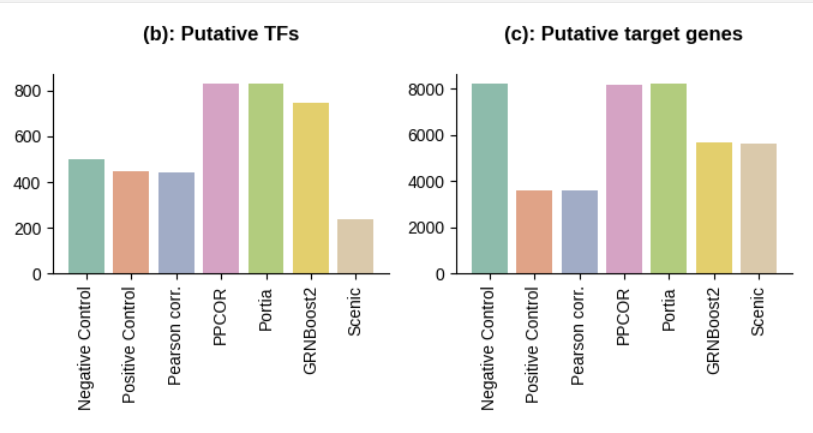

### nakatake

In [7]:
df_scores = pd.read_csv(f"resources/scores/nakatake/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000815,-0.000943,0.000648,0.024343,0.047426,7
positive_control,0.000333,0.000933,0.050172,0.195597,0.103299,1
pearson_corr,0.002183,0.006059,0.042007,0.177372,0.092215,3
portia,0.000026,0.001641,0.044538,0.094127,0.071015,4
ppcor,-0.000114,-0.000657,0.004380,0.028708,0.049842,6
grnboost2,-0.001190,-0.001845,0.023334,0.179273,0.144886,2
scenic,0.003915,0.006797,0.005719,0.078472,0.091197,5


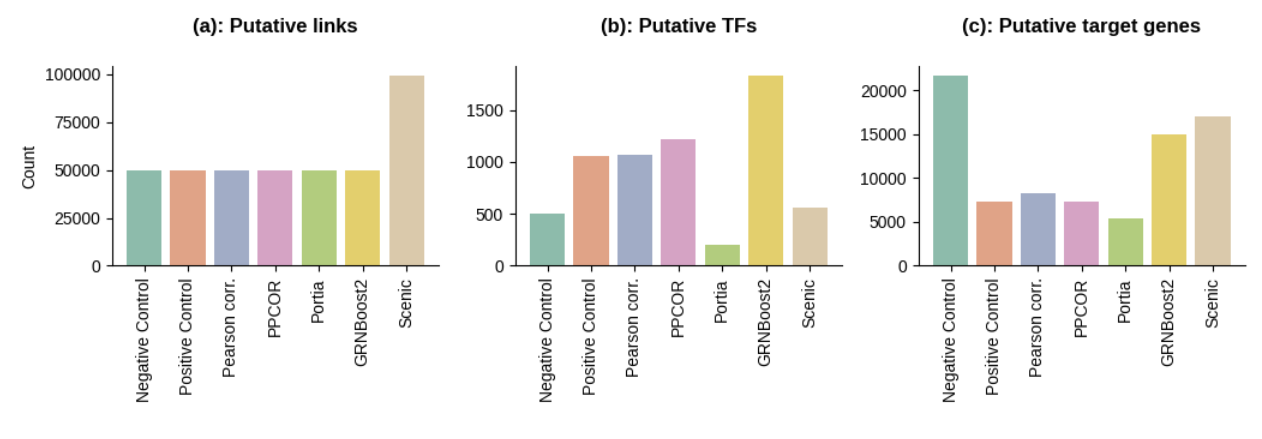

### norman 

In [8]:
df_scores = pd.read_csv(f"resources/scores/norman/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000234,-0.000256,0.014227,0.013110,0.003253,7
positive_control,-0.002901,-0.003470,0.136180,0.098129,0.040224,2
pearson_corr,0.001870,0.002176,0.135031,0.092110,0.036152,3
portia,-0.002051,-0.002247,0.064202,0.037832,0.009061,5
ppcor,0.001867,0.002047,0.093536,0.052257,0.011904,4
grnboost2,0.000263,0.000314,0.114651,0.101651,0.056132,1
scenic,0.001586,0.004122,0.084830,0.022496,0.005257,6


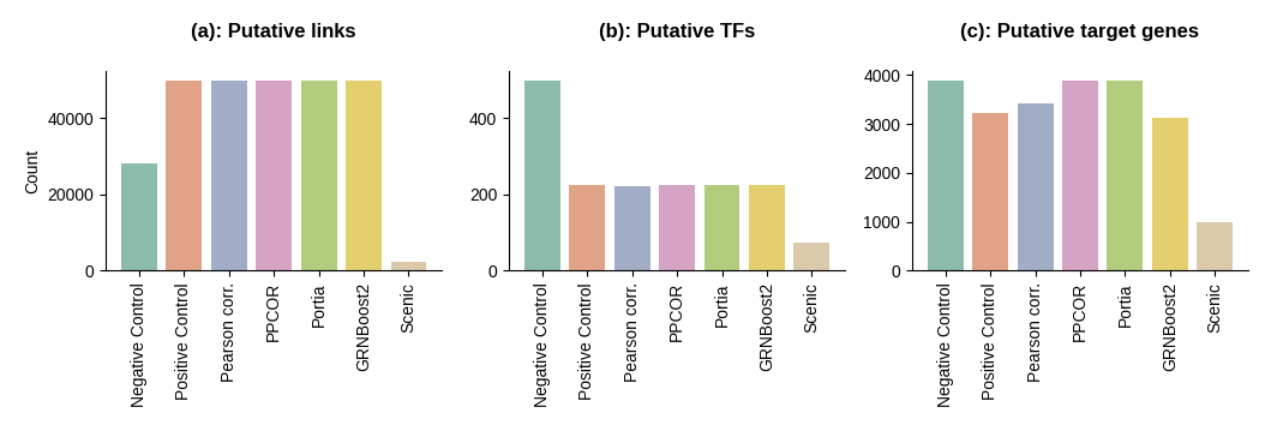

In [10]:
!ls resources/scores/adamson/

50000-skeleton_False-binarize_True-ridge.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv


### adamson

In [12]:
df_scores = pd.read_csv(f"resources/scores/adamson/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.022322,0.022322,0.445594,0.439009,0.413479,5
positive_control,-0.021639,-0.027437,0.664241,0.482923,0.436312,2
pearson_corr,0.024375,0.030097,0.652753,0.481473,0.435883,3
portia,-0.022940,-0.023618,0.341579,0.371780,0.401550,6
ppcor,-0.017781,-0.017927,0.555375,0.453831,0.423552,4
grnboost2,-0.011154,-0.013385,0.679135,0.503771,0.451201,1


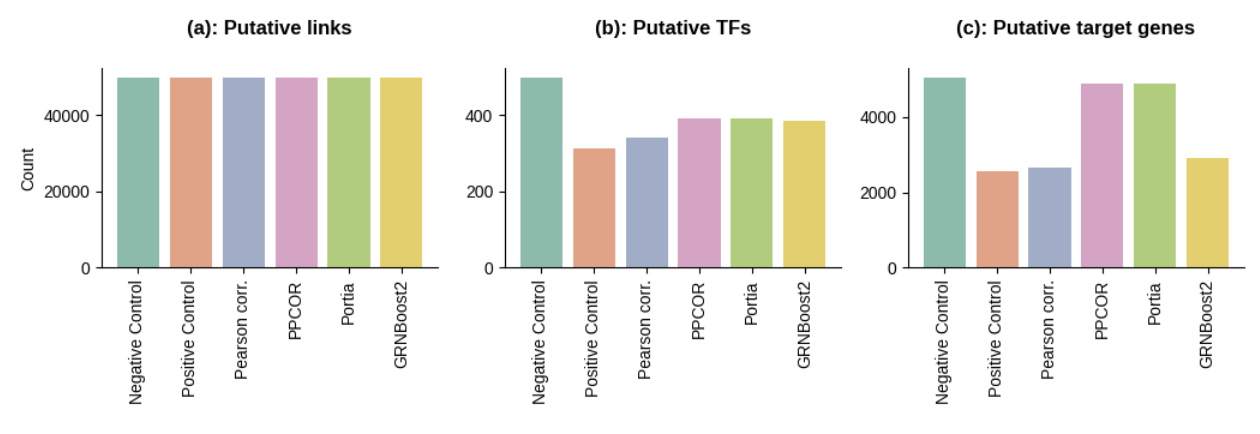

### Global models

In [119]:
!ls resources/scores/op/

50000-skeleton_False-binarize_True-GB.csv
50000-skeleton_False-binarize_True-ridge.csv
lognorm-50000-skeleton_False-binarize_True-ridge-global-False.csv
nets
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv


In [121]:
df_scores_gb = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv", index_col=0)
df_scores = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)

df_scores = pd.concat([df_scores, df_scores_gb])
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
collectri,0.058315,0.126899,0.229779,0.272409,0.290769,13
negative_control,-0.000923,-0.000961,0.193640,0.260667,0.290877,19
positive_control,0.721750,1.188803,0.654297,0.411675,0.310124,2
pearson_corr,0.570333,1.048355,0.580583,0.379891,0.303594,4
portia,0.465527,0.674097,0.513885,0.317206,0.298095,7
ppcor,0.196689,0.238486,0.362190,0.289743,0.291190,10
grnboost2,0.735540,0.923076,0.581265,0.471491,0.329940,1
scenic,0.318873,0.467008,0.519103,0.406525,0.317489,6
granie,0.147522,0.193977,0.165400,0.211497,0.283239,21
scglue,0.155642,0.678908,0.499250,0.293863,0.293939,8


# Format resourcs used

In [13]:
if True: 
    # job_ids_dict_hvg = { 
    #     'portia': 7744548,
    #     'grnboost2': 7742249,
    #     'scenic': 7742283,
    #     'genie3': 7742285,
    #     'ppcor': 7742364,
    #     'scglue': 7742343,
    # }

    job_ids_dict = { 
        'portia': 7751292,
        'grnboost2': 7747906,
        'scenic': 7748219,
        'ppcor': 7748321,
        'scglue': [7756286, 7756675],
        'scenicplus': [7761874, 7760439, 7760554],
        'figr': 7756664,
        'celloracle': 7761872,
        'pearson_corr': 7770044,
        'positive_control': 7770047,
        'negative_control':7770048 
    }
    
    df_res = process_trace_local(job_ids_dict)
    df_res = df_res[['Elapsed', 'MaxVMSize']]
    granie = pd.DataFrame({'Elapsed':  3643.337/60/60, 'MaxVMSize': 41},index=['granie'])
    df_res = pd.concat([df_res, granie], axis=0)
    df_res.columns = ['Duration (hour)', 'Peak memory (GB)']


## Merge scores with resources

In [112]:
# - collect all the scores
for i, dataset in enumerate(datasets):
    df_scores = pd.read_csv(f"resources/scores/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
    # - normalize scores 
    df_scores = df_scores.fillna(0)
    df_scores[df_scores < 0] = 0
    df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
    df_scores = df_scores.reset_index().melt(id_vars='index', var_name='metric', value_name='r2score').rename(columns={'index':'model'})
    df_scores['dataset'] = dataset
    if i == 0:
        df_all = df_scores
    else:
        df_all = pd.concat([df_all, df_scores], axis=0)


In [115]:
df_all = df_all[~(df_all['model'] == 'collectri')]

In [116]:
# - mean scores for metrics
def mean_for_metrics(df):
    metric = df['metric'].values.flatten()[0]
    if metric in ['S1','S2']:
        df = df[df['dataset']=='op']
    else:
        pass 
    return df[['r2score']].mean()
df_metrics = df_all.groupby(['model','metric']).apply(lambda df: mean_for_metrics(df)).reset_index().pivot(index='model', columns='metric', values='r2score')

# - mean scores for datasets
def mean_for_datasets(df):
    dataset = df['dataset'].values.flatten()[0]
    if dataset != 'op':
        df = df[~df['metric'].isin(['S1','S2'])]
    else:
        pass 
    return df[['r2score']].mean()
df_datasets = df_all.groupby(['model','dataset']).apply(lambda df: mean_for_datasets(df)).reset_index().pivot(index='model', columns='dataset', values='r2score')

/vol/tmp/users/jnourisa/ipykernel_1636782/208795827.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_all.groupby(['model','metric']).apply(lambda df: mean_for_metrics(df)).reset_index().pivot(index='model', columns='metric', values='r2score')
/vol/tmp/users/jnourisa/ipykernel_1636782/208795827.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_datasets = df_all.groupby(['model','data

In [117]:
# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 

df_summary.method_name = df_summary.method_name.map(surragate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Control': 10, 
                            'Pearson corr.': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Control': 10,
                            'GRaNIE': 6,
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary

,method_name,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,adamson,nakatake,norman,op,replogle2,overall_score,Duration (hour),Peak memory (GB),User-friendly,Complexity
3,GRNBoost2,1.000000,0.776475,0.826432,0.980936,1.000000,1.000000,0.787585,0.941155,0.925419,1.000000,0.923800,7.510556,7.378796,8,2
7,Positive Control,0.981252,1.000000,0.958346,0.860857,0.633513,0.832683,0.857764,0.886458,0.865377,0.729077,0.860533,0.015000,11.601669,10,0
10,Scenic+,0.800199,0.634004,0.913697,0.983595,0.888349,0.000000,0.000000,0.000000,0.843969,0.000000,0.843969,11.740556,131.342854,1,9
5,Pearson corr.,0.775394,0.881858,0.880661,0.792117,0.556792,0.814796,0.729421,0.834992,0.718003,0.692485,0.767652,0.041389,23.801899,10,0
0,CellOracle,0.633710,0.641349,0.843619,0.773048,0.561766,0.000000,0.000000,0.000000,0.690699,0.000000,0.690699,3.765000,41.601166,6,4
6,Portia,0.632905,0.567038,0.523610,0.337081,0.235700,0.000000,0.511919,0.266277,0.527488,0.569957,0.417198,2.491111,55.685230,9,1
11,scGLUE,0.211603,0.571086,0.682864,0.316799,0.229125,0.000000,0.000000,0.000000,0.402295,0.000000,0.402295,11.097500,61.677879,6,4
9,Scenic,0.433522,0.392839,0.437852,0.350487,0.345024,0.000000,0.289197,0.240945,0.606671,0.245343,0.371320,24.008611,35.954300,7,3
1,FigR,0.305938,0.449542,0.252149,0.345278,0.265239,0.000000,0.000000,0.000000,0.323629,0.000000,0.323629,6.731667,225.208725,6,4
8,PPCOR,0.267408,0.200610,0.360093,0.285175,0.165767,0.566048,0.041881,0.418685,0.268351,0.033865,0.260788,13.425833,64.136433,7,3


## Summary figure

In [118]:

summary_file = "output/summary.tsv"
summary_figure = "output/summary_figure.pdf"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../grn_benchmark/src/summary_figure.R {summary_file} {summary_figure}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (21): ...1, S1, S2, static-theta-0.0, static-theta-0.5, static-theta-1.0...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18 × 7
   id               id_color         name       group geom  palette options     
   <c

# Robustness analysis

In [25]:
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh # !python src/robustness_analysis/script_all.py
base_dir = 'resources/results/robustness_analysis'

Submitted batch job 7770049


In [26]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

## Permute net

In [27]:
# net 
noise_type = 'net'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [28]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132838,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063194,-0.037703,0.258300,0.201382,0.094161,-0.016007,0.246858,0.117373,0.052529,0.046615,0.159076,0.085768,0.259247
20,-0.068023,-0.038826,0.232850,0.188608,0.076579,-0.025485,0.213148,0.103506,0.043782,0.037751,0.145942,0.079237,0.243952
50,-0.075000,-0.037746,0.182995,0.174772,0.020020,0.005844,0.099969,0.057258,0.005112,-0.019924,0.099687,0.052120,0.147341
100,-0.084617,-0.038591,-0.009365,-0.045844,-0.052908,-0.064681,-0.057610,-0.016075,-0.004035,-0.045894,-0.019244,-0.013468,-0.006252


In [29]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.337533,0.316130,0.501373,0.447392,0.268367,0.335675,0.467258,0.354542,0.514954
10,0.310607,0.300799,0.433080,0.427072,0.337533,0.314340,0.492975,0.439982,0.263060,0.334209,0.453522,0.356273,0.506758
20,0.312346,0.298023,0.428219,0.416558,0.334752,0.307381,0.481193,0.427551,0.268367,0.330640,0.444836,0.351414,0.498718
50,0.305605,0.301245,0.413182,0.397406,0.322203,0.301887,0.442722,0.399035,0.288905,0.320246,0.407539,0.344040,0.464195
100,0.295797,0.303241,0.379001,0.345088,0.291961,0.286424,0.293421,0.317192,0.318627,0.289704,0.310580,0.316354,0.321514


## Permute sign

In [30]:
noise_type = 'sign'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [31]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063294,-0.037943,0.244253,0.175927,0.068840,-0.026427,0.225111,0.097068,0.043191,0.039099,0.130693,0.066178,0.232978
20,-0.078692,-0.037331,0.195138,0.143907,0.030350,-0.041580,0.162380,0.059698,0.023835,0.021276,0.078184,0.049052,0.183118
50,-0.080401,-0.034971,-0.016077,0.001196,-0.000673,0.006405,-0.085877,-0.047863,0.000526,-0.019741,0.010997,-0.007829,-0.006821
100,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561


In [32]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257013,0.335675,0.467258,0.354542,0.514954
10,0.315233,0.298546,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257063,0.335675,0.467258,0.354542,0.514954
20,0.315206,0.298645,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256943,0.335675,0.467258,0.354542,0.514954
50,0.315729,0.299033,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256891,0.335675,0.467258,0.354542,0.514954
100,0.314412,0.298592,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257129,0.335675,0.467258,0.354542,0.514954


## Permute weight

In [33]:
noise_type = 'weight'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

# repo

In [34]:
# if par['metacell']:
#     print('metacell')
#     def create_meta_cells(df, n_cells=15):
#         meta_x = []
#         for i in range(0, df.shape[0], n_cells):
#             meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
#         df = pd.DataFrame(meta_x, columns=df.columns)
#         return df
            
#     adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
#     adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
#     adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
#     df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
#     X = df.values
#     var = pd.DataFrame(index=df.columns)
#     obs = df.reset_index()[['cell_type','donor_id']]
#     multiomics_rna = ad.AnnData(X=X, obs=obs, var=var)